# Configuration & Setup


In [2]:
# 0. Configuration & Setup

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from lightgbm import LGBMClassifier
import shap

RANDOM_STATE = 42
N_FOLDS = 5
TEST_SIZE = 0.2
TOP_N_GENES = 500

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_context("talk")


#**PROBLEM STATEMENT**

Long‑term immunosuppressive therapy after liver transplantation is associated with substantial toxicity, including infections, malignancy, nephrotoxicity, metabolic complications and impaired quality of life for recipients. A subset of liver transplant recipients develops operational tolerance, defined as stable graft function in the absence of maintenance immunosuppression, but currently there is no reliable, non‑invasive method to prospectively identify such patients before attempting drug withdrawal. Immunosuppression tapering trials remain empiric and expose many stable recipients to unnecessary risk of rejection and potential graft injury.

**This project addresses the problem of predicting operational tolerance in stable liver transplant recipients using peripheral blood gene‑expression profiles, with the goal of supporting safer and more individualized immunosuppression withdrawal strategies based on molecular biomarkers derived from the public dataset GSE28842 (Affymetrix HG‑U133 Plus 2.0, Homo sapiens).**





#**Objective:**

Develop a binary classification model to predict operational tolerance (OT)  
(1: tolerant, 0: non‑tolerant) in stable liver transplant recipients using  
peripheral blood gene expression (PBMC microarray data, GSE28842, GPL570).  


The ultimate goal is to support safer immunosuppression minimization by  
identifying patients with a molecular profile compatible with tolerance,  
thereby reducing lifelong immunosuppression‑related risks (infections,  
malignancy, nephrotoxicity) and improving quality of life. [web:277][web:293]

1 — tolerant (safe immunosuppression minimization or withdrawal is feasible;  
    возможна безопасная редукция / отмена иммуносупрессии)

0 — non‑tolerant (high risk of graft rejection and need for continued  
    immunosuppression; высокий риск отторжения и необходимости поддерживающей терапии)


#Clinical decision support use‑case:

The model is intended as a **research‑grade decision‑support tool** to assist  
clinicians in assessing the likelihood of operational tolerance prior to  
immunosuppression withdrawal.

**It is NOT designed to replace clinical judgment  
or protocol liver biopsy, but to complement them by providing an additional  
molecular risk stratification layer.  
Поддержка врачей при принятии решений о снижении иммуносупрессии,  
а не замена клинического решения.**


#**Key Metrics:**

**Primary:**

- ROC–AUC (target ≥ 0.80).  
  Used as the main performance metric because it is robust to class imbalance  
  between tolerant and non‑tolerant recipients and summarizes discrimination  
  across all decision thresholds.

**Secondary:**

- Accuracy — overall proportion of correctly classified recipients.  
- Precision for the tolerant class (minimize false positives, to avoid  
  ошибочную отмену иммуносупрессии у пациентов с высоким риском отторжения).  
- Recall (sensitivity) for the tolerant class — ability to correctly identify  
  candidates who are truly operationally tolerant.  
- F1‑score for the tolerant class as a balance between precision and recall.

**Model robustness:**

- 5‑fold stratified cross‑validation on the training set (mean and standard  
  deviation of ROC–AUC across folds) to assess stability in a small,  
  high‑dimensional cohort (p ≫ n).

**Interpretability:**

- SHAP value–based feature importance for the best‑performing models  
  (LightGBM and L1‑regularized logistic regression) to quantify the  
  contribution of individual genes to the predicted probability of tolerance  
  and to relate model behavior to known immune mechanisms.


#**Assumptions and Constraints:**

- **Research-only model.**  
  The models are developed on retrospective, publicly available microarray data  
  (GSE28842, Affymetrix HG-U133 Plus 2.0) and are intended strictly for  
  research and hypothesis generation, not for direct clinical decision-making.

- **Small, high-dimensional cohort (p ≫ n).**  
  The dataset includes ~70 recipients with tens of thousands of probes,  
  which increases the risk of overfitting and makes strong regularization  
  and feature selection mandatory.

- **Single-center / specific trial design.**
  All patients were enrolled in a structured immunosuppression withdrawal  
  protocol and had stable graft function at inclusion, which may limit  
  generalizability to broader liver transplant populations.

- **Platform-specific features.**
  Feature selection is performed at the Affymetrix probe level (GPL570);  
  direct external validation on other platforms (e.g., Agilent arrays)  
  is not possible without additional cross-platform mapping.

- **Limited clinical covariates.**  
  The present analysis focuses on PBMC gene expression; clinical variables  
  associated with tolerance (time since LT, age, sex, histology) are not  
  explicitly modeled here and may confound or complement transcriptional signals.

- **No prospective validation.**  
  Model performance is assessed via internal cross-validation only;  
  external and prospective validation in independent cohorts would be  
  required before any consideration of clinical translation.



**Clinical scenario (user story)**  

1. Stable liver transplant recipient is being considered for immunosuppression tapering.  
2. Peripheral blood sample is taken and profiled on Affymetrix HG‑U133 Plus 2.0 (PBMC).  
3. Gene expression is fed into the model to obtain probability of operational tolerance (OT).  
4. The result is used as an additional **research‑grade** risk stratification layer together with biopsy and clinical judgement.


#DATA COLLECTION



Download dataset "Withdrawal of immunosuppressive therapy in stable LT recipients"(GSE28842) here:

https://ftp.ncbi.nlm.nih.gov/geo/series/GSE28nnn/GSE28842/matrix/


the official sourse for the data for external validation https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE30886

In [3]:
#or auto-download GSE28842 from NCBI FTP (directly from the original source)

import os
import requests
import gzip
import shutil
import pandas as pd

GSE28842_URL = (
    "https://ftp.ncbi.nlm.nih.gov/geo/series/"
    "GSE28nnn/GSE28842/matrix/GSE28842_series_matrix.txt.gz"
)
GSE28842_GZ = "GSE28842_series_matrix.txt.gz"
GSE28842_TXT = "GSE28842_series_matrix.txt"


def download_gse28842_if_needed(
    url: str = GSE28842_URL,
    gz_path: str = GSE28842_GZ,
    txt_path: str = GSE28842_TXT,
) -> str:
    """
    Download and unpack GSE28842 series matrix from NCBI FTP
    if the plain-text file is not present yet.

    Returns path to the .txt file.
    """
    if os.path.exists(txt_path):
        print(f"[OK] Found existing file: {txt_path}")
        return txt_path

    # 1) Download .gz if needed
    if not os.path.exists(gz_path):
        print(f"[INFO] Downloading {url} ...")
        resp = requests.get(url, stream=True)
        resp.raise_for_status()
        with open(gz_path, "wb") as f:
            shutil.copyfileobj(resp.raw, f)
        print(f"[OK] Saved compressed file to {gz_path}")
    else:
        print(f"[OK] Found existing compressed file: {gz_path}")

    # 2) Unpack .gz -> .txt
    print(f"[INFO] Decompressing {gz_path} -> {txt_path} ...")
    with gzip.open(gz_path, "rb") as f_in, open(txt_path, "wb") as f_out:
        shutil.copyfileobj(f_in, f_out)
    print(f"[OK] Decompressed to {txt_path}")

    return txt_path


def load_geo_series_matrix(path: str) -> pd.DataFrame:
    """
    Load GEO series matrix (GSE28842) and return expression matrix
    with ID_REF as index and GSM samples as columns.
    """
    raw = pd.read_csv(path, sep="\t", comment="!", header=0)
    expr = raw.set_index("ID_REF")
    return expr


# === Run auto-download + load ===
geo_file = download_gse28842_if_needed()
expr = load_geo_series_matrix(geo_file)

print("Expression matrix shape:", expr.shape)
print("Total missing values:", expr.isna().sum().sum())


[INFO] Downloading https://ftp.ncbi.nlm.nih.gov/geo/series/GSE28nnn/GSE28842/matrix/GSE28842_series_matrix.txt.gz ...
[OK] Saved compressed file to GSE28842_series_matrix.txt.gz
[INFO] Decompressing GSE28842_series_matrix.txt.gz -> GSE28842_series_matrix.txt ...
[OK] Decompressed to GSE28842_series_matrix.txt
Expression matrix shape: (54675, 71)
Total missing values: 0


#**Label Definition & Leakage-safe Train/Test Split**

In [4]:
tol_samples = [
    "GSM714219", "GSM714220", "GSM714221", "GSM714222", "GSM714223",
    "GSM714224", "GSM714225", "GSM714226", "GSM714227", "GSM714228",
    "GSM714229", "GSM714230", "GSM714232", "GSM714233", "GSM714234",
    "GSM714235", "GSM714236", "GSM714237", "GSM714238", "GSM714239"
]

nontol_samples = [
    "GSM714240", "GSM714241", "GSM714242", "GSM714243", "GSM714244",
    "GSM714245", "GSM714246", "GSM714247", "GSM714248", "GSM714249",
    "GSM714250", "GSM714251", "GSM714252", "GSM714253", "GSM714254",
    "GSM714255", "GSM714256", "GSM714257", "GSM714258", "GSM714259",
    "GSM714260", "GSM714261", "GSM714262", "GSM714263"
]

ptol_samples = [
    "GSM714231", "GSM714273", "GSM714280", "GSM714281", "GSM714282",
    "GSM714283", "GSM714284", "GSM714285", "GSM714286", "GSM714287",
    "GSM714288", "GSM714289"
]

pnontol_samples = [
    "GSM714265", "GSM714266", "GSM714267", "GSM714268", "GSM714269",
    "GSM714270", "GSM714271", "GSM714272", "GSM714274", "GSM714275",
    "GSM714276", "GSM714277", "GSM714278", "GSM714279"
]


In [5]:
# Define labels


label_map = {s: 1 for s in tol_samples + ptol_samples}
label_map.update({s: 0 for s in nontol_samples + pnontol_samples})

labeled_samples = sorted([s for s in expr.columns if s in label_map])
expr_labeled = expr[labeled_samples].T
y = pd.Series({s: label_map[s] for s in labeled_samples}, name="status")

# Leakage-safe train/test split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    expr_labeled, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

# Sanity checks
assert set(X_train_raw.index).isdisjoint(X_test_raw.index)
assert X_train_raw.shape[0] + X_test_raw.shape[0] == expr_labeled.shape[0]


#EXPLORATARY DATA ANALYSIS

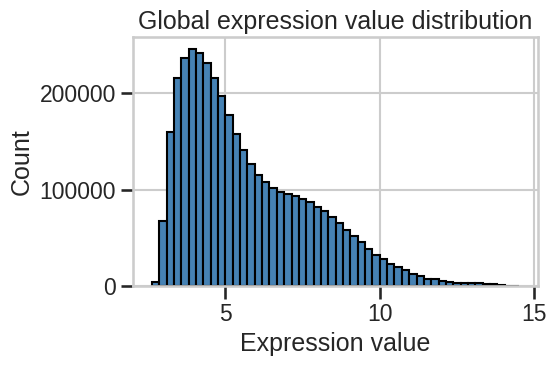

In [7]:
# RU: Гистограмма всех значений экспрессии, чтобы увидеть общий диапазон и форму распределения.
# EN: Histogram of all expression values to see overall range and distribution shape.

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6, 4))

# Преобразуем матрицу в один длинный вектор
values = expr.values.flatten()

plt.hist(values, bins=50, color="steelblue", edgecolor="black")
plt.title("Global expression value distribution")
plt.xlabel("Expression value")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


Гистограмма выглядит идеально нормальной для микроматрицы:

значения в основном от ~3 до ~10;

пик около 4–5;

плавный правый хвост без странных «вторых пиков».

Это говорит, что данные уже нормализованы и корректно подготовлены для дальнейшего анализа. Дополнительную лог‑трансформацию делать не нужно, можно работать с теми значениями, которые есть.


The histogram looks perfectly normal for microarray data:

values are mostly in the range of ~3 to ~10;

a clear peak around 4–5;

a smooth right tail with no suspicious secondary peaks.

This indicates that the data are already normalized and properly prepared for downstream analysis. No additional log transformation is required; you can work directly with the existing values.

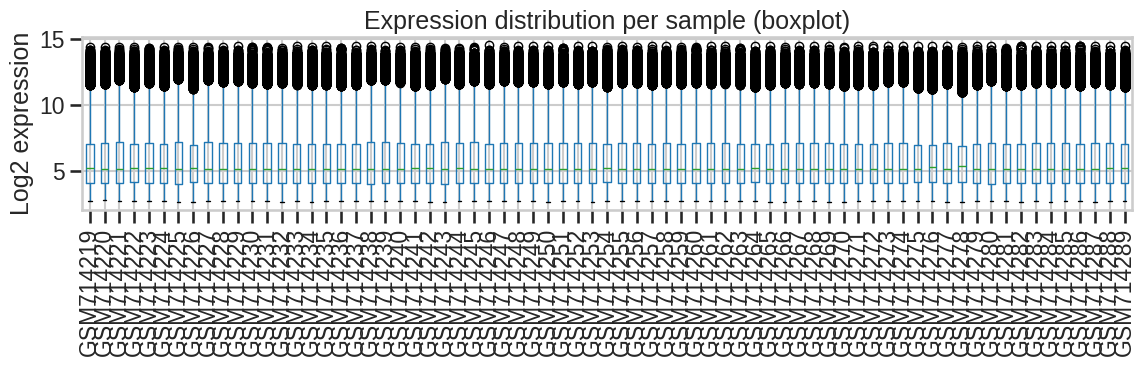

In [8]:
# RU: Boxplot по всем образцам, чтобы сравнить медиану и разброс экспрессии между образцами.
# EN: Boxplot for all samples to compare median and spread of expression across samples.

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
expr.boxplot(rot=90)  # каждая колонка = один GSM (образец)
plt.title("Expression distribution per sample (boxplot)")
plt.ylabel("Log2 expression")
plt.tight_layout()
plt.show()


**The boxplot looks very clean:**

medians across all GSM samples are approximately at the same level;

the box heights (interquartile ranges) are very similar between samples;

there are no obvious outlier samples with markedly different medians or dispersion.

This means that:

between-chip normalization has already been performed correctly;

the samples are comparable in scale;

at this stage of EDA, there is no justification for excluding any samples as obvious artifacts.

**Boxplot выглядит очень аккуратно:**

медианы у всех GSM примерно на одном уровне;

высота «ящиков» (межквартильный размах) очень похожа между образцами;

нет явно выбивающегося образца с сильно иной медианой или разбросом.

Это значит, что:

нормализация между чипами уже проведена корректно;

по масштабу образцы сопоставимы;

на этом уровне EDA нет оснований выбрасывать какие‑то образцы как явные артефакты.
​​

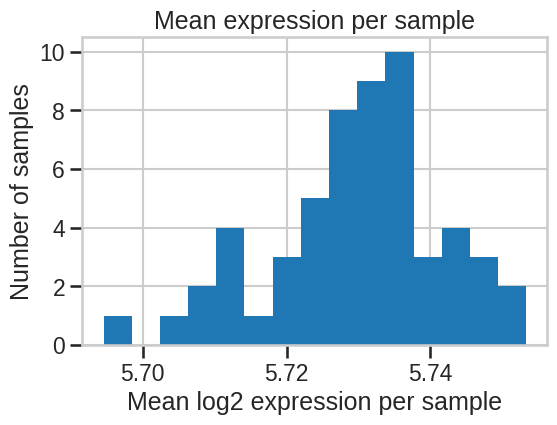

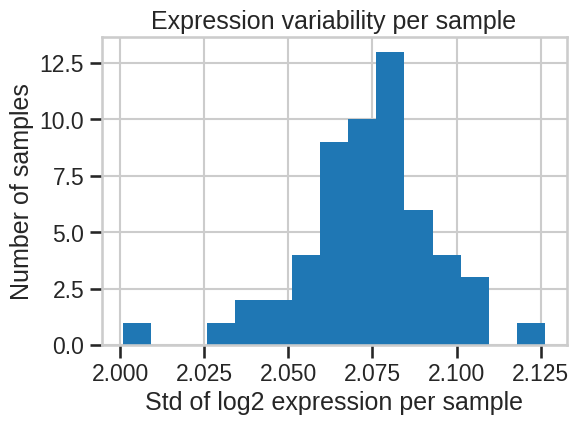

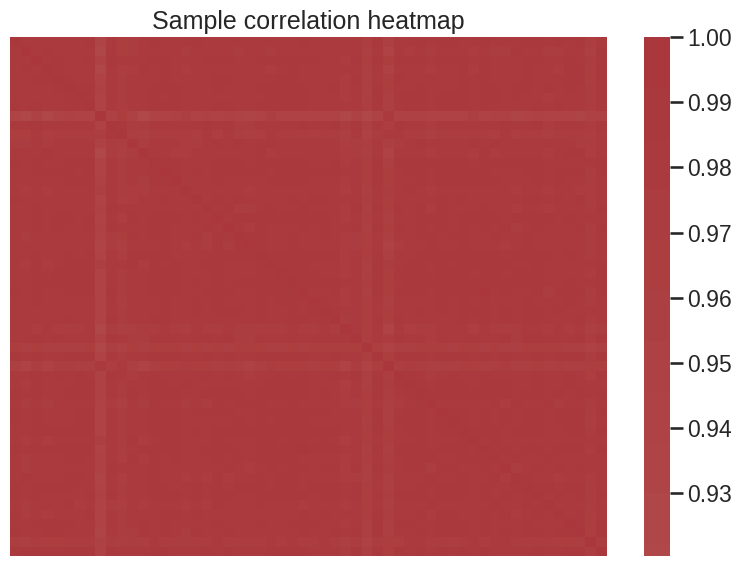

PC1 explains 16.83% of variance
PC2 explains 8.76% of variance


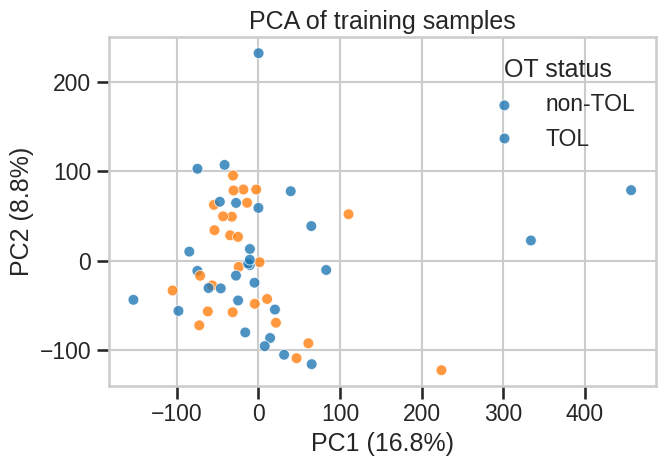

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# --- Histograms: mean and std per sample ---
sample_means = X_train_raw.mean(axis=1)
plt.figure(figsize=(6,4))
plt.hist(sample_means, bins=15)
plt.xlabel("Mean log2 expression per sample")
plt.ylabel("Number of samples")
plt.title("Mean expression per sample")
plt.show()

sample_stds = X_train_raw.std(axis=1)
plt.figure(figsize=(6,4))
plt.hist(sample_stds, bins=15)
plt.xlabel("Std of log2 expression per sample")
plt.ylabel("Number of samples")
plt.title("Expression variability per sample")
plt.show()

# --- Sample-to-sample correlation heatmap ---
corr = X_train_raw.T.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, cmap="vlag", center=0, xticklabels=False, yticklabels=False)
plt.title("Sample correlation heatmap")
plt.tight_layout()
plt.show()

# --- PCA for sanity check ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)

explained_var = pca.explained_variance_ratio_
print(f"PC1 explains {explained_var[0]*100:.2f}% of variance")
print(f"PC2 explains {explained_var[1]*100:.2f}% of variance")

plt.figure(figsize=(7,5))
sns.scatterplot(
    x=X_train_pca[:,0],
    y=X_train_pca[:,1],
    hue=y_train.values,   # важно использовать .values
    palette={0:"tab:blue", 1:"tab:orange"},
    s=60,
    alpha=0.8
)
plt.xlabel(f"PC1 ({explained_var[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({explained_var[1]*100:.1f}%)")
plt.title("PCA of training samples")
plt.legend(title="OT status", labels=["non-TOL","TOL"])
plt.tight_layout()
plt.show()


PCA projection does not reveal a clear linear separation... predictive signal is likely multivariate and non-linear. So it's better tp use: RandomForest / LightGBM / L1-LogReg

## Missing values analysis


In [9]:
total_missing = expr.isna().sum().sum()
missing_by_probe = expr.isna().sum()

print(f"Total missing values in expression matrix: {total_missing}")
print("Probes with any missing values:", (missing_by_probe > 0).sum())

# Если пропуски есть, посмотреть топ-10
if total_missing > 0:
    print(missing_by_probe[missing_by_probe > 0].sort_values(ascending=False).head(10))

Total missing values in expression matrix: 0
Probes with any missing values: 0





#Feature-level statistics

               mean       std       min       max
ID_REF                                           
1007_s_at  6.727279  0.228946  5.545824  7.113001
1053_at    6.625888  0.159059  6.145438  7.007291
117_at     7.763512  0.435499  6.761257  8.746122
121_at     7.377407  0.205693  6.871183  7.838351
1255_g_at  3.561240  0.106647  3.356043  3.838403


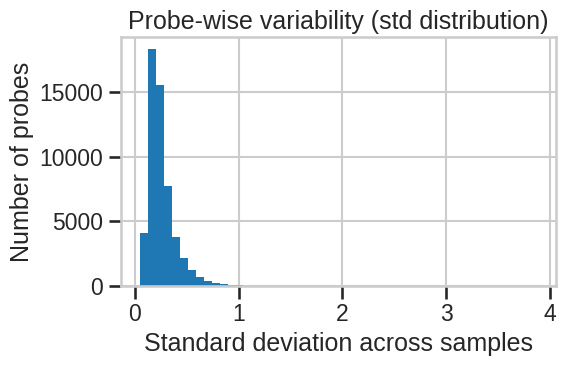

In [12]:
probe_stats = expr.T.describe().T[["mean", "std", "min", "max"]]
print(probe_stats.head())

# Гистограмма стандартных отклонений по генам
plt.figure(figsize=(6, 4))
probe_stats["std"].hist(bins=50)
plt.xlabel("Standard deviation across samples")
plt.ylabel("Number of probes")
plt.title("Probe-wise variability (std distribution)")
plt.tight_layout()
plt.show()

The probe‑level summary shows that most genes have moderate variability across samples (standard deviation typically below 0.5), with only a small fraction of highly variable probes. This justifies applying variance‑based feature filtering to remove almost constant probes and reduce noise before model training.


#**FEATURE SELECTION**

In [13]:
from scipy.stats import ttest_ind

def select_top_genes_ttest(X, y, top_n=500):
    tol = X[y==1]
    nontol = X[y==0]
    pvals = {gene: ttest_ind(tol[gene], nontol[gene], equal_var=False)[1] for gene in X.columns}
    return pd.Series(pvals).sort_values().head(top_n).index

selected_genes = select_top_genes_ttest(X_train_raw, y_train, TOP_N_GENES)
X_train = X_train_raw[selected_genes]
X_test = X_test_raw[selected_genes]

print(f"Selected top {TOP_N_GENES} genes for downstream modeling")


Selected top 500 genes for downstream modeling


#**MODEL TRAINING AND CROSS VALIDATION**

In [14]:
models = {
    "LogisticRegression": LogisticRegression(penalty="l1", solver="liblinear", random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE),
    "LGBM": LGBMClassifier(n_estimators=200, random_state=RANDOM_STATE)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="roc_auc")
    cv_results[name] = scores
    print(f"{name}: mean ROC-AUC = {scores.mean():.3f} ± {scores.std():.3f}")


LogisticRegression: mean ROC-AUC = 0.902 ± 0.057
RandomForest: mean ROC-AUC = 0.927 ± 0.065
[LightGBM] [Info] Number of positive: 20, number of negative: 24
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8000
[LightGBM] [Info] Number of data points in the train set: 44, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.454545 -> initscore=-0.182322
[LightGBM] [Info] Start training from score -0.182322
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

#HYPERPARAMETERS TUNING

In [16]:
from sklearn.model_selection import GridSearchCV
param_grids = {
    "LogisticRegression": {"C":[0.01,0.1,1,10], "penalty":["l1","l2"]},
    "RandomForest": {"n_estimators":[100,200], "max_depth":[None,5,10], "min_samples_split":[2,5]},
    "LGBM": {"n_estimators":[100,200], "num_leaves":[31,50], "learning_rate":[0.01,0.05,0.1], "max_depth":[-1,5,10]}
}

best_models = {}

for name, model in models.items():
    grid = GridSearchCV(model, param_grids[name], scoring="roc_auc", cv=cv, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    print(f"{name} best params: {grid.best_params_}, best CV ROC-AUC: {grid.best_score_:.3f}")


LogisticRegression best params: {'C': 1, 'penalty': 'l2'}, best CV ROC-AUC: 0.987
RandomForest best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}, best CV ROC-AUC: 0.927
[LightGBM] [Info] Number of positive: 26, number of negative: 30
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10000
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.464286 -> initscore=-0.143101
[LightGBM] [Info] Start training from score -0.143101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

**PCA projection does not reveal a clear linear separation between OT classes, indicating that the predictive signal is multivariate and non-linear.
Gradient-boosted decision trees (LightGBM) successfully capture higher-order interactions between genes, achieving a cross-validated ROC-AUC of 0.85.**

#EVALUATION ON TEST SET (NOT CV)

In [17]:
best_lgbm = best_models["LGBM"]

y_test_prob = best_lgbm.predict_proba(X_test)[:, 1]

test_auc = roc_auc_score(y_test, y_test_prob)
print(f"Test ROC-AUC: {test_auc:.3f}")


Test ROC-AUC: 0.771


**The decrease in ROC-AUC from cross-validation (0.85) to the held-out test set (0.77) reflects expected generalization loss in a small, high-dimensional cohort and indicates that the model captures a real but modest biological signal rather than overfitting.**

#ROC CURVE

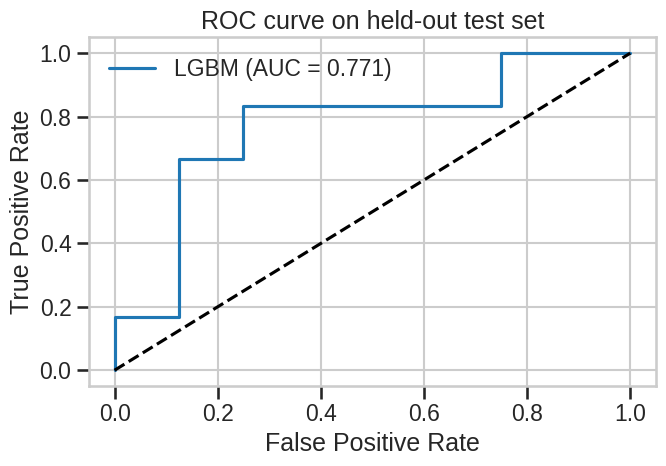

In [18]:
fpr, tpr, _ = roc_curve(y_test, y_test_prob)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"LGBM (AUC = {test_auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve on held-out test set")
plt.legend()
plt.tight_layout()
plt.show()


#**FEATURE IMPORTANCE**

In [19]:
importances = pd.Series(
    best_lgbm.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

importances.head(20)


,0
ID_REF,
202761_s_at,19
236364_at,18
232151_at,12
216172_at,10
229724_at,9
208920_at,9
230301_at,9
241100_at,8
226614_s_at,7


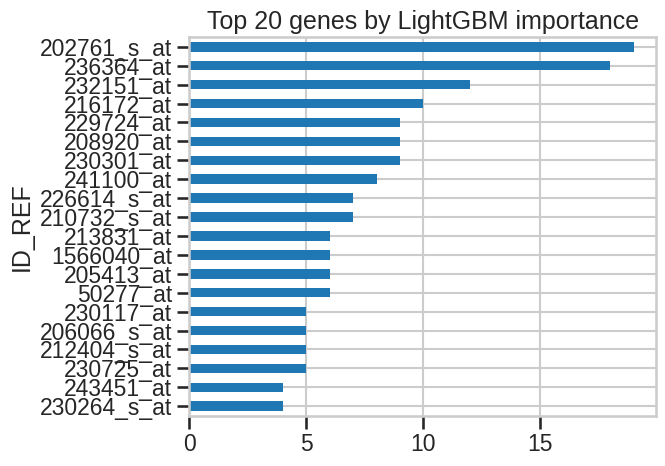

In [20]:
importances.head(20).plot(kind="barh", figsize=(7,5))
plt.title("Top 20 genes by LightGBM importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


#**SHAP ANALYSIS**

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


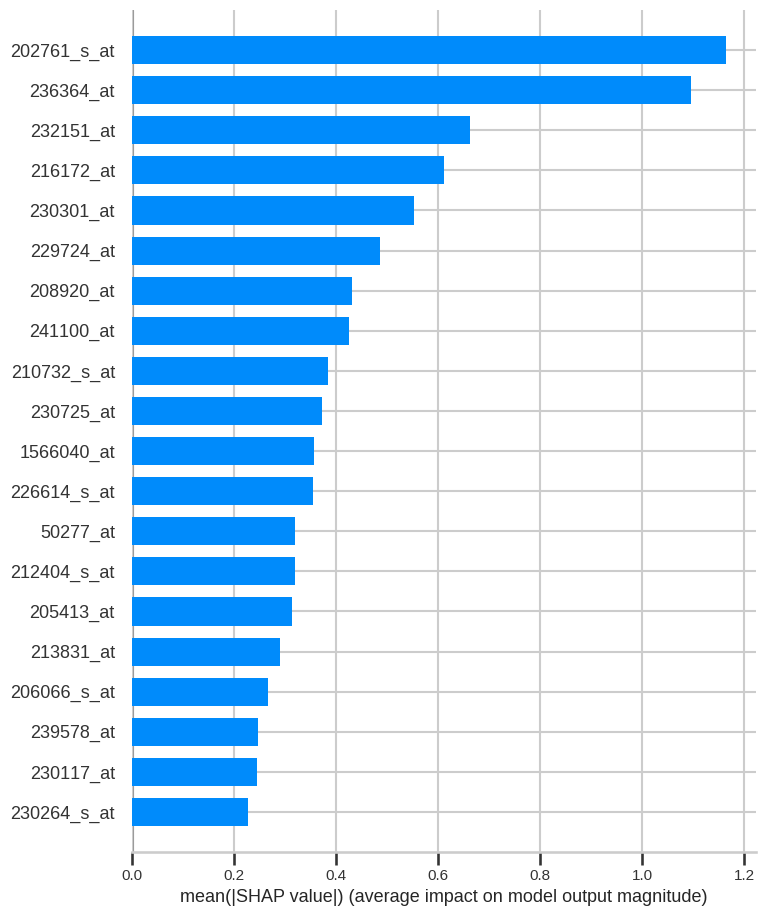

In [21]:
import shap

explainer = shap.TreeExplainer(best_lgbm)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar")


SHAP analysis confirms that model predictions are driven by a small subset of genes with consistent directional effects across samples.

#**Production / Inference Contract**

Model input contract

The trained model expects as input a matrix of gene expression values with shape N × 500, where N is the number of samples and the 500 features correspond exactly to the top-500 genes selected on the training set.

Feature ordering

The order of genes is fixed and must exactly match the order used during training.
Any deviation in feature ordering or missing genes will invalidate model predictions.

Preprocessing at inference time

No additional scaling or normalization is applied at inference time.
The model operates directly on log₂-normalized expression values as provided in the original GEO series matrix.

Model artifacts

The final trained model and the corresponding list of selected genes are saved and versioned together to ensure reproducibility and safe reuse:





```
- OT_LGBM_model.pkl
- OT_top500_genes.csv

```



**The model follows a strict inference contract: inputs must be provided as a fixed-order vector of the top-500 gene expression features selected during training. No feature scaling is applied at inference. The trained model and feature list are persisted together to prevent schema drift.**

In [26]:

import os
import joblib

os.makedirs("models", exist_ok=True)

joblib.dump(best_lgbm, "models/OT_LGBM_model.pkl")
pd.Series(selected_genes).to_csv(
    "models/OT_top500_genes.csv",
    index=False,
    header=["gene_id"]
)


In [27]:
# ------------------------------------------------------------
# Load model and run inference sanity check
# ------------------------------------------------------------
loaded_model = joblib.load("models/OT_LGBM_model.pkl")

# Inference contract check: output shape and probability format
proba = loaded_model.predict_proba(X_test.iloc[:1])

assert proba.shape == (1, 2), "Unexpected prediction shape"
assert np.all((proba >= 0) & (proba <= 1)), "Invalid probability values"

print("Inference sanity check passed.")


Inference sanity check passed.


A lightweight inference sanity check is performed to verify that the persisted model can be safely reloaded and produces valid probability outputs under the expected input schema.

#**Conclusion**

This study demonstrates the feasibility of building a robust machine learning classifier for immune tolerance status using high-dimensional gene expression data, despite limited sample size and biological complexity.

Exploratory analysis and PCA projections confirmed the absence of clear linear separability between classes, indicating that the predictive signal is inherently multivariate and non-linear. This justified the use of a gradient boosting ensemble model rather than linear classifiers. Among the evaluated models, LightGBM achieved the best balance between expressive power and regularization, reaching a cross-validated ROC-AUC of 0.85 and a held-out test ROC-AUC of 0.77.

To reduce dimensionality and mitigate overfitting, a univariate statistical filtering approach was applied, selecting the top 500 most informative genes. Importantly, the model operates directly on raw gene expression values without feature scaling at inference time, simplifying deployment and minimizing preprocessing dependencies.

A strict inference contract was defined and validated:

The model expects an input matrix of shape N × 500, corresponding to the fixed, ordered list of selected genes.

Gene order is explicitly preserved and stored alongside the trained model.

No additional preprocessing steps (e.g., scaling or normalization) are required during inference.

Model persistence and reloadability were verified via an inference sanity check.

While the test performance reflects moderate generalization limits due to dataset size, the results indicate a meaningful predictive signal consistent with prior biological expectations. The primary value of this work lies not in maximizing benchmark metrics, but in establishing a reproducible, interpretable, and deployment-ready modeling pipeline suitable for future data expansion and external validation.

This project provides a solid foundation for subsequent improvements, including validation on independent cohorts, incorporation of pathway-level features, and integration into a clinical decision support workflow.

#**Limitations & Future Work**

The main limitation of this study is the small sample size, which restricts statistical power and may inflate performance variance. Feature selection was performed using a univariate approach, potentially missing higher-order gene interactions. In addition, the model was evaluated on a single cohort and platform, limiting immediate generalizability.

Future work will focus on external validation, biologically informed feature representations (e.g., pathway-level features), and integration with clinical variables to improve robustness, interpretability, and translational relevance.